In this notebook, I will demonstrate how to write a microfluidic serpentine with TipSlicer. This serpentine is defined by a programmatic function myFigure in which the 'image' for a given height is returned. This matrix is similar to the mask that would be send to a photolithograpy printer for that layer. White means there is material, black means there isn't. The basic functions allowing to define bends and channels are defined in a separate Python file Serpentin.py. 

For the stitching, the different choices of algorithms as used in the 'adaptive stitching paper' are present, you of course can only use 1 of them at a time. Concorde can then be used for the toolpath planning but the nearest neighbour algorithm is available if need be. 

In [1]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import TipSlicer
import cv2
import scipy.ndimage as im
import tables
from importlib import reload
import os
import Serpentin

In [3]:
x=arange(-8000,8000,5)
y=arange(-2000,2000,5)
X,Y=np.meshgrid(x,y)
print(X.shape)

(800, 3200)


In [4]:
# here the use with a formula instead of a STL is shown
def myFigure(X,Y,z,extraPs):
    thick=extraPs[0]
   
    startX=-7500
    startY=0
    chanLen=2000
    bendRad=500
    orientation=0
    entLen=1000
    
    phi=np.deg2rad(30)
    omega=np.deg2rad(15)
    theta=np.deg2rad(10)
    
    heightChannel=100
    heightGrooves=20
    
    T,eX,eY,bL=Serpentin.makeSerpentin(X,Y,startX,startY,thick,entLen,chanLen,bendRad,5,0)
    
    if (z<=heightChannel):
        return T
    else:
        if (z<=heightChannel+heightGrooves):
            G=np.zeros(T.shape,dtype=np.uint8)
            for bb in bL:
                if ((bb[4]==180) and (bb[5]==360)):
                    G=Serpentin.makeGrooves(G,bb[0],bb[1],bb[2],bb[3],phi,omega,theta,doBottom=False)
                elif ((bb[4]==180) and (bb[5]==0)):
                    G=Serpentin.makeGrooves(G,bb[0],bb[1],bb[2],bb[3],phi,omega,theta,doBottom=True)
            return G
        else:
            return np.zeros(T.shape,dtype=np.uint8)
    
    
    

In [5]:
width=108

In [6]:
T=myFigure(X,Y,0,[width])
clf()
imshow(T,cmap=cm.gray_r)


In [7]:
%%%time
optPoints=TipSlicer.getOptimalStitchCentres(T,150,150,X,Y)

CPU times: user 58 s, sys: 3.32 s, total: 1min 1s
Wall time: 1min 1s


In [26]:
optPoints=TipSlicer.getHexStitchCentres(T,150,X,Y)

In [28]:
optPoints=TipSlicer.getSquareStitchCentres(T,150/np.sqrt(2),X,Y)

In [12]:
optPoints=TipSlicer.getOptimalStitchCentres_Bulk(T,150,150,X,Y)

In [8]:
%%%time
# now find optimal solution with CONCORDE and CPLEX
pp=optPoints
TipSlicer.writeTSPfile('blocks.tsp',pp)
!concorde -o 'tsp.sol' 'blocks.tsp'
Ord=TipSlicer.readTSPfile('tsp.sol')

concorde -o tsp.sol blocks.tsp
Host: lapsam  Current process id: 5710
Using random seed 1512405971
Problem Name: blocks
Problem Type: TSP
Nanoscribe Blocks in Ham Path
Number of Nodes: 179
Explicit Lengths (CC_MATRIXNORM)
Set initial upperbound to 53590 (from tour)
  LP Value  1: 53590.000000  (0.00 seconds)
New lower bound: 53590.000000
Final lower bound 53590.000000, upper bound 53590.000000
Exact lower bound: 53590.000000
DIFF: 0.000000
Final LP has 179 rows, 285 columns, 570 nonzeros
Optimal Solution: 53590.00
Number of bbnodes: 1
Total Running Time: 0.05 (seconds)
CPU times: user 41.6 ms, sys: 9.9 ms, total: 51.5 ms
Wall time: 205 ms


In [9]:
clf()
plot(pp[Ord][:,0],pp[Ord][:,1],'o-')

If you do not have concorde, you can try the following nearest neighbour algorithm

In [55]:
Ord,NNd=TipSlicer.TSPnearest(optPoints)

In [10]:
pp_pix=TipSlicer.convertToPixels(X,Y,pp)

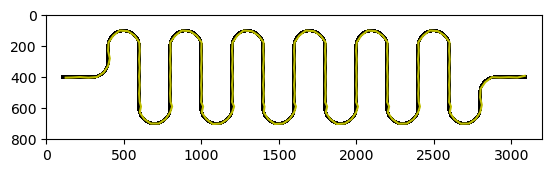

In [11]:
clf()
plot(pp_pix[Ord][:,0],pp_pix[Ord][:,1],'y-')
#plot(pp_pix[NNp][:,0],pp_pix[NNp][:,1],'r-')
imshow(T,cmap=cm.gray_r)
display(gcf())

# Now write to GWL

In [13]:
reload(TipSlicer)

<module 'FormulaSlicer' from '/home/sam/ULB/Source Code/PythonScripts3/FormulaSlicer.py'>

In [12]:
regions, vertices = TipSlicer.makeVoronoiPolygons(optPoints)

In [14]:
#%%%time
# STEP 5: Write out stacks
FovZ=120
Fov=300
hatching=0.5
slicing=2

amShells=10
ScaffStep=40 # for solid infill => 2*hatching is spacing here
hatchStep=1 # for contour distance and top-bottom infill, not used if amShells==1 and doTopBottom=False
#CodeSpeeds=np.ones(3)*30000
#CodeIntensities=np.ones(3)*80


am=np.int(np.round(Fov/hatching))
#amY=np.int(np.round(FovY/hatching))
zz=np.arange(0,FovZ,slicing)


dirName='GroovedSerpentin_108opt_120bis'
if (not os.path.exists(dirName)):
    os.mkdir(dirName)
genBlockName=dirName+'/'+dirName+'Block-{:05d}.h5'
genGwlName=dirName+'/'+dirName+'Block-{:05d}.gwl'
genRegex=dirName+'/.+gwl'
fullGwlName=dirName+'.gwl'
distList=[]

for i in np.arange(len(Ord)):
#for i in np.arange(5):
    # now make coordinate systems
    print('Writing block {}'.format(i))
    xc=optPoints[Ord[i],0]
    yc=optPoints[Ord[i],1]
    polygon = vertices[regions[Ord[i]]]

    xx=np.linspace(xc-Fov/2.0,xc+Fov/2.0,am)
    yy=np.linspace(yc-Fov/2.0,yc+Fov/2.0,am)
    Xloc,Yloc=np.meshgrid(xx,yy)
    
    MM=TipSlicer.makeVoronoiMask(polygon,Xloc,Yloc)
    # if you need overlap, do binary_dilation on the mask
    MM=im.binary_dilation(MM,iterations=3)
    
    # with these coordinate systems, apply formulaToStack
    blockName=genBlockName.format(i)
    
    TipSlicer.formulaToStack(blockName,Xloc,Yloc,zz,myFigure,extraParams=[width],writingMask=MM)
    
    # and write the GWL's
    dists=TipSlicer.stackToGwl(blockName,genGwlName.format(i),amShells,ScaffStep,hatchStep
                                   ,atAngles=-1,writeHeader=False,writeColourH5=False,doTopBottom=True)
    try:
        distList.append(dists)
    except:
        print('Could not add dist to list',dists)
    
TipSlicer.writeGwlForRegex(fullGwlName,genRegex)

Writing block 0
Writing block 1
Writing block 2
Writing block 3
Writing block 4


In [16]:
print(dists)

[ 1053112.52704478   154062.25743299  1002478.24956602]


In [32]:
print(len(distList))

295


In [33]:
DD=np.asarray(distList)
print(DD.shape)

(295,)


In [23]:
print(np.sum(DD,axis=0))

[  1.75325570e+08   2.53050725e+07   1.70377413e+08]


# Calculating Contour length of all masks and amount of blocks

In [155]:
def calcContLength(optPoints,vertices,regions,Fov,am,myFigure,width):
    contList=[]
    for i in np.arange(len(optPoints)):
    #for i in np.arange(5):
        # now make coordinate systems
        #print('Writing block {}'.format(i))
        xc=optPoints[i,0]
        yc=optPoints[i,1]
        polygon = vertices[regions[i]]

        xx=np.linspace(xc-Fov/2.0,xc+Fov/2.0,am)
        yy=np.linspace(yc-Fov/2.0,yc+Fov/2.0,am)
        Xloc,Yloc=np.meshgrid(xx,yy)

        MM=TipSlicer.makeVoronoiMask(polygon,Xloc,Yloc)
        # if you need overlap, do binary_dilation on the mask
        MM=im.binary_dilation(MM,iterations=3)

        T=myFigure(Xloc,Yloc,0,[width])
        Rs=cv2.Canny((MM*T).astype(np.uint8),0.5,0.5)

    #    MaskList.append(MM*T)
        contList.append(Rs.sum())
    #ML=np.asarray(MaskList)
    CC=np.asarray(contList)
    return CC.sum()

In [ ]:
# Now make big loop!!

In [168]:
ShellList=[]
BlockList=[]
Widths=np.linspace(10,700,100)
for w in Widths:
    T=myFigure(X,Y,0,[w])
    optPoints=TipSlicer.getOptimalStitchCentres(T,150,150,X,Y)
    BlockList.append(len(optPoints))
    regions, vertices = TipSlicer.makeVoronoiPolygons(optPoints)
    sh=calcContLength(optPoints,vertices,regions,Fov,am,myFigure,w)
    ShellList.append(sh)
SH_Opt=np.asarray(ShellList)
BL_Opt=np.asarray(BlockList)

In [191]:
savetxt('Shell_Opt.txt',SH_Opt)

In [160]:
Widths=np.linspace(20,700,10)

In [161]:
clf()
plot(Widths,SH,'o')

In [166]:
ShellList=[]
BlockList=[]
Widths=np.linspace(10,700,100)
for w in Widths:
    T=myFigure(X,Y,0,[w])
    optPoints=TipSlicer.getHexStitchCentres(T,150,X,Y)
    BlockList.append(len(optPoints))
    regions, vertices = TipSlicer.makeVoronoiPolygons(optPoints)
    sh=calcContLength(optPoints,vertices,regions,Fov,am,myFigure,w)
    ShellList.append(sh)
SH_Hex=np.asarray(ShellList)
BL_Hex=np.asarray(BlockList)

In [190]:
savetxt('Shell_Hex.txt',SH_Hex)

In [192]:
ShellList=[]
BlockList=[]
Widths=np.linspace(10,700,100)
for w in Widths:
    T=myFigure(X,Y,0,[w])
    optPoints=TipSlicer.getSquareStitchCentres(T,150/np.sqrt(2),X,Y)
    BlockList.append(len(optPoints))
    regions, vertices = TipSlicer.makeVoronoiPolygons(optPoints)
    sh=calcContLength(optPoints,vertices,regions,Fov,am,myFigure,w)
    ShellList.append(sh)
SH_Sq=np.asarray(ShellList)
BL_Sq=np.asarray(BlockList)

In [193]:
savetxt('Shell_Sq.txt',SH_Sq)

In [194]:
ShellList=[]
BlockList=[]
Widths=np.linspace(10,700,100)
for w in Widths:
    T=myFigure(X,Y,0,[w])
    optPoints=TipSlicer.getOptimalStitchCentres_Bulk(T,150,150,X,Y)
    BlockList.append(len(optPoints))
    regions, vertices = TipSlicer.makeVoronoiPolygons(optPoints)
    sh=calcContLength(optPoints,vertices,regions,Fov,am,myFigure,w)
    ShellList.append(sh)
SH_Bulk=np.asarray(ShellList)
BL_Bulk=np.asarray(BlockList)


In [195]:
savetxt('Shell_Bulk.txt',SH_Bulk)

In [12]:
Widths=np.linspace(10,700,100)
hatching=0.5
SH_Opt=np.loadtxt('Shell_Opt.txt')
SH_Bulk=np.loadtxt('Shell_Bulk.txt')
SH_Hex=np.loadtxt('Shell_Hex.txt')
SH_Sq=np.loadtxt('Shell_Sq.txt')

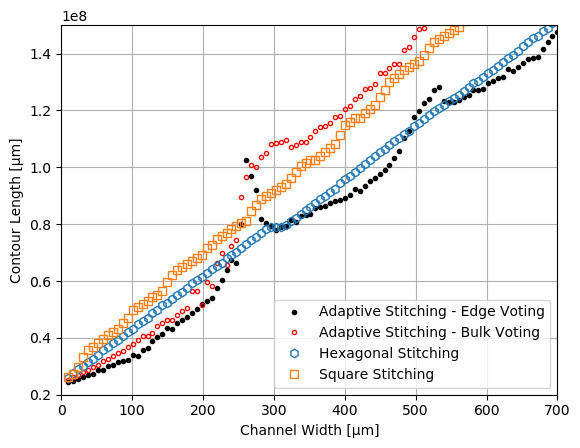

In [15]:
clf()
plot(Widths,SH_Opt*hatching,'.',color='k',label='Adaptive Stitching - Edge Voting')
plot(Widths,SH_Bulk*hatching,'.',color='r',markerfacecolor='none',label='Adaptive Stitching - Bulk Voting')
plot(Widths,SH_Hex*hatching,'h',markerfacecolor='none',label='Hexagonal Stitching')
plot(Widths,SH_Sq*hatching,'s',markerfacecolor='none',label='Square Stitching')
grid()
legend(loc=4)
ylim(0.2e8,1.5e8)
xlim(0,700)
xlabel('Channel Width [µm]')
ylabel('Contour Length [µm]')
display(gcf())


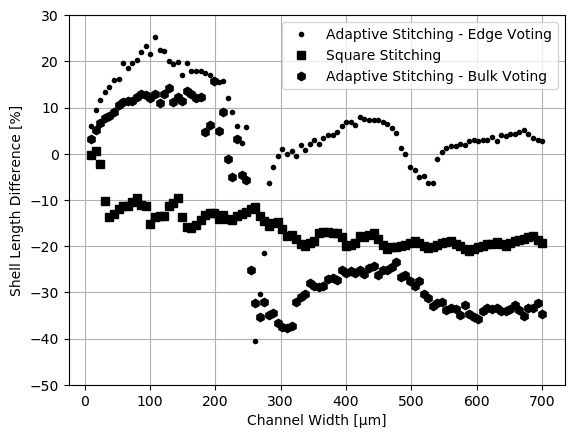

In [17]:
clf()
plot(Widths,(SH_Hex-SH_Opt)*100/SH_Hex,'.',color='k',label='Adaptive Stitching - Edge Voting')
plot(Widths,(SH_Hex-SH_Sq)*100/SH_Hex,'s',color='k',label='Square Stitching')
plot(Widths,(SH_Hex-SH_Bulk)*100/SH_Hex,'h',color='k',label='Adaptive Stitching - Bulk Voting')
ylim(-50,30)
#plot(Widths,SH_Bulk,'.',color='r',markerfacecolor='none',label='Adaptive Stitching - Bulk Voting')
#plot(Widths,SH_Hex*hatching,'h',markerfacecolor='none',label='Hexagonal Stitching')
#plot(Widths,SH_Sq,'s',markerfacecolor='none',label='Square Stitching')
grid()
legend()
xlabel('Channel Width [µm]')
ylabel('Shell Length Difference [%]')
display(gcf())